In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt

from matplotlib.mlab import PCA as mlabPCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA 

import pprint
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 100)

# Choose default aesthetic
sns.set_style("white")

In [2]:
df = pd.read_csv("Titanic_train.csv")

In [3]:
df.rename(columns={"PassengerId":"ID", "Pclass":"Class", "Parch":"ParCh"}, inplace=True)
df.head()

,ID,Survived,Class,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Embarkment cities are Southampton (Eng.), Cherbourg (Fr.), and Queenstown (Ire.), in order

In [4]:
df.dtypes

ID            int64
Survived      int64
Class         int64
Name         object
Sex          object
Age         float64
SibSp         int64
ParCh         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [5]:
# Fill in the 'Cabin' NaN's with a 'None'
df.Cabin.fillna(value='None', inplace=True)
df.head()
df.Embarked.value_counts()
#df.describe(include='all')

S    644
C    168
Q     77
Name: Embarked, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


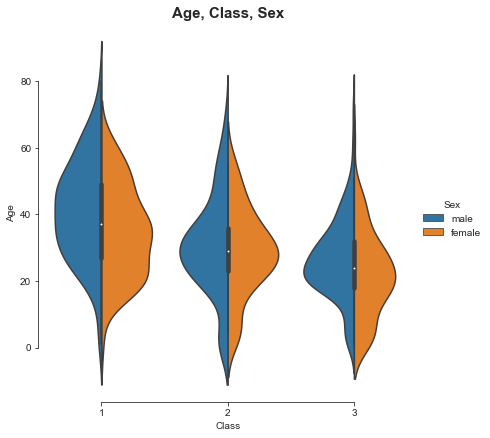

In [6]:
sns.set_style("ticks")
sns.catplot(x="Class", y="Age", hue="Sex",
            kind="violin", split=True, data=df, height=6);
plt.title("Age, Class, Sex", fontsize=15, fontweight='bold')
sns.despine(trim=True)
plt.show()

## Make pair grid, just as in tutorial; I tried doing without jitter, and it's definitely better with

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


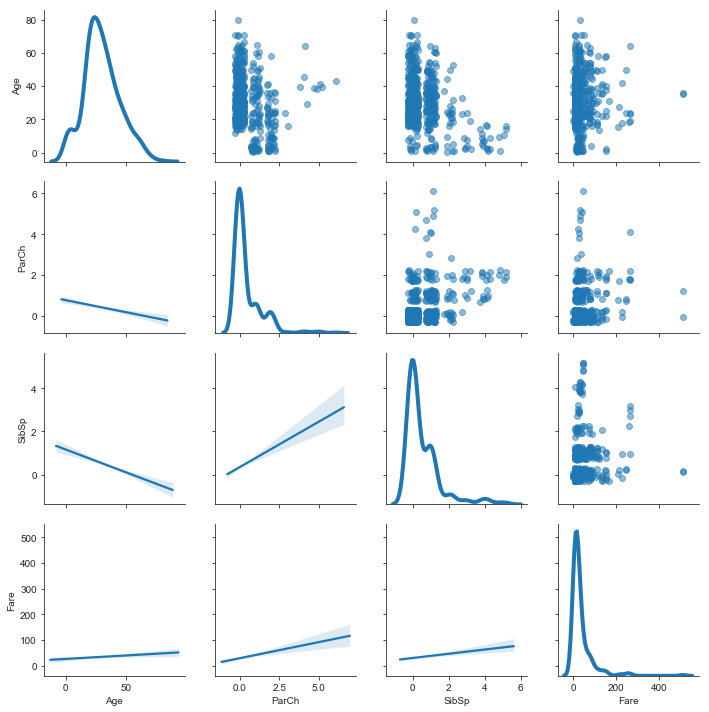

In [7]:
df_jittered = df.loc[:, ['Age', 'ParCh', 'SibSp', 'Fare']].dropna()

jitter = pd.DataFrame(np.random.uniform(-.3, .3, size=(df_jittered.shape)), columns=df_jittered.columns)
df_jittered = df_jittered.add(jitter)

# Going to do a matrix with all the numeric variables
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False, palette='dark')

# Map the scatter() function onto the upper portion of the map (portion above diagonal line)
g.map_upper(plt.scatter, alpha=.5)

# Map regplot() to create fit lines on lower portion
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Map kdeplot() to give some distribution info
g.map_diag(sns.kdeplot, lw=4)

plt.show()

## Some correlation and some inverse correlation here

          Class       Age     ParCh     SibSp      Fare
Class  1.000000 -0.369226  0.025683  0.067247 -0.554182
Age   -0.369226  1.000000 -0.189119 -0.308247  0.096067
ParCh  0.025683 -0.189119  1.000000  0.383820  0.205119
SibSp  0.067247 -0.308247  0.383820  1.000000  0.138329
Fare  -0.554182  0.096067  0.205119  0.138329  1.000000


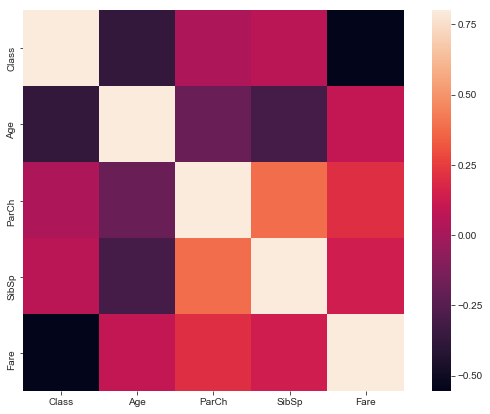

In [8]:
# I'm adding 'Class' in here, though it's essentially categorical; adds interest
df_corr = df.loc[:, ['Class', 'Age', 'ParCh', 'SibSp', 'Fare']].dropna()

# Correlation matrix
corrmat = df_corr.corr()
print(corrmat)

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [9]:
def disp_cont_cat(category):
    """
    IN: variable (dataframe column) which should be categorical
    OUT: displays boxplots
    
    Info: this function pairs up the passed categorical variable with the 
    continuous variables and plots the relationship
    """
    
    # The four variables hard-coded here are continuous, and get
    # rolled down with the categorical ID variable for better display;
    # pd.melt() uses the id_var, and creates 2 new columns: 'variable', 'value'
    df_ext = df[['Age', 'SibSp', 'ParCh', 'Fare', category]]
    df_ext = pd.melt(df_ext, id_vars=[category])

    g = sns.FacetGrid(df_ext, col="variable", sharey=False, size=5, aspect=.4)
    g = g.map(sns.boxplot, category, "value", notch=True, color='brown')
    plt.show()

    
def stats_cont_cat(category):
    """
    IN: variable (dataframe column) which should be categorical
    OUT: descriptive statistics
    
    Info: this function pairs up the passed categorical variable with the 
    continuous variables and calculates stats
    """
    for var in ['Age', 'SibSp', 'ParCh', 'Fare']:
        print(df[[var, category]].groupby(category).describe())
        print("\n")

        
def ttest_cont_cat(category):
    """
    IN: variable (dataframe column) which should be categorical
    OUT: displays Ttest / Pvalue stats
    
    Info: this function pairs up the passed categorical variable with the 
    continuous variables and calculates Ttest / Pvalue
    """  
    for col in ['Age', 'SibSp', 'ParCh', 'Fare', category]:
        print(f"{col}: ", stats.ttest_ind(df[df[category] == 0][col].dropna(),
                                          df[df[category] == 1][col].dropna()))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


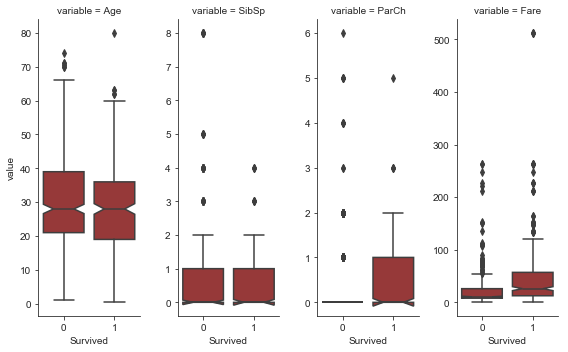

            Age                                                    
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0


          SibSp                                             
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  0.553734  1.288399  0.0  0.0  0.0  1.0  8.0
1         342.0  0.473684  0.708688  0.0  0.0  0.0  1.0  4.0


          ParCh                                             
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  0.329690  0.823166  0.0  0.0  0.0  0.0  6.0
1         342.0  0.464912  0.771712  0.0  0.0  0.0  1.0  5.0


           Fare                             

In [10]:
disp_cont_cat('Survived')
stats_cont_cat('Survived')
ttest_cont_cat('Survived')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


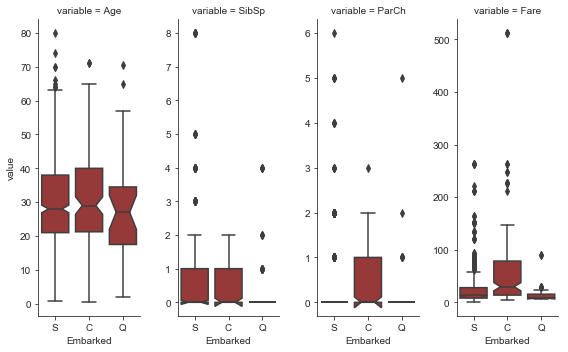

            Age                                                     
          count       mean        std   min    25%   50%   75%   max
Embarked                                                            
C         130.0  30.814769  15.434860  0.42  21.25  29.0  40.0  71.0
Q          28.0  28.089286  16.915396  2.00  17.50  27.0  34.5  70.5
S         554.0  29.445397  14.143192  0.67  21.00  28.0  38.0  80.0


          SibSp                                             
          count      mean       std  min  25%  50%  75%  max
Embarked                                                    
C         168.0  0.386905  0.557213  0.0  0.0  0.0  1.0  2.0
Q          77.0  0.428571  0.979105  0.0  0.0  0.0  0.0  4.0
S         644.0  0.571429  1.216600  0.0  0.0  0.0  1.0  8.0


          ParCh                                             
          count      mean       std  min  25%  50%  75%  max
Embarked                                                    
C         168.0  0.363095  0.6604

In [11]:
disp_cont_cat('Embarked')
stats_cont_cat('Embarked')
#ttest_cont_cat('Embarked')                # not displaying, turns out they're NaN

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


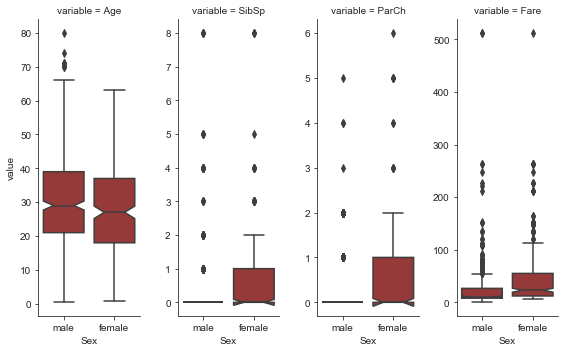

          Age                                                    
        count       mean        std   min   25%   50%   75%   max
Sex                                                              
female  261.0  27.915709  14.110146  0.75  18.0  27.0  37.0  63.0
male    453.0  30.726645  14.678201  0.42  21.0  29.0  39.0  80.0


        SibSp                                             
        count      mean       std  min  25%  50%  75%  max
Sex                                                       
female  314.0  0.694268  1.156520  0.0  0.0  0.0  1.0  8.0
male    577.0  0.429809  1.061811  0.0  0.0  0.0  0.0  8.0


        ParCh                                             
        count      mean       std  min  25%  50%  75%  max
Sex                                                       
female  314.0  0.649682  1.022846  0.0  0.0  0.0  1.0  6.0
male    577.0  0.235702  0.612294  0.0  0.0  0.0  0.0  5.0


         Fare                                                             

In [12]:
disp_cont_cat('Sex')
stats_cont_cat('Sex')
#ttest_cont_cat('Sex')                    # not displaying, turns out they're NaN

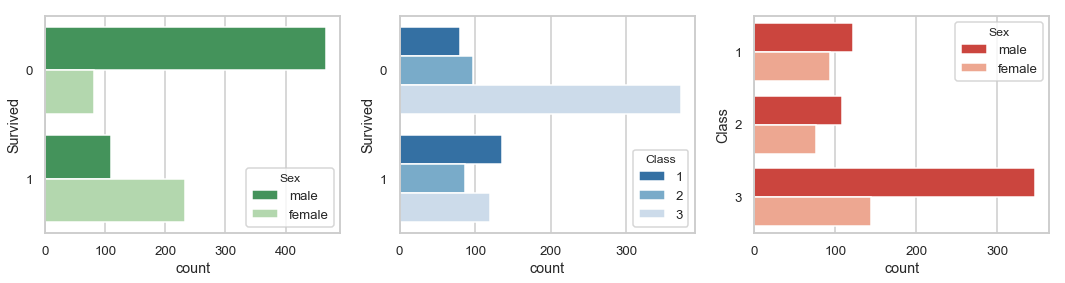

In [13]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)
fig, axes = plt.subplots(1, 3, figsize=[18,4])

sns.countplot(y="Survived", hue="Sex", data=df, palette="Greens_r", ax=axes[0])
#axes[0].set_ylabel("Survived", fontsize=12, fontweight='bold')
#axes[0].set_xlabel("Count", fontsize=12, fontweight='bold')

sns.countplot(y="Survived", hue="Class", data=df, palette="Blues_r", ax=axes[1])
sns.countplot(y="Class", hue="Sex", data=df, palette="Reds_r", ax=axes[2])
   
plt.show()

In [14]:
table = pd.crosstab(df['Survived'], df['Sex'])
print(table)
print(stats.chisquare(table, axis=None))

table = pd.crosstab(df['Survived'], df['Class'])
print("\n", table)
print(stats.chisquare(table, axis=None))

Sex       female  male
Survived              
0             81   468
1            233   109
Power_divergenceResult(statistic=418.7867564534231, pvalue=1.8861714255214322e-90)

 Class       1   2    3
Survived              
0          80  97  372
1         136  87  119
Power_divergenceResult(statistic=418.2188552188552, pvalue=3.507238245057369e-88)


## Time to make features

In [15]:
df.head()

,ID,Survived,Class,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [16]:
# Does embarkment point affect survival?
# I bet it does, based on demographics of the cities at that time
features = pd.get_dummies(df['Embarked'])

# Will rework these a bit, but they all likely have some effect
for name in ['Class', 'Age', 'SibSp', 'ParCh', 'Fare']:
    features[name] = df.loc[:, name]

# Pretty sure sex is important to survival, especially in that era
features['Female'] = np.where(df['Sex'] == 'female', 1, 0)

# Lots of fares in the mid-$200's, only 3 above; going to reset those 3
#sorted(features.Fare.values, reverse=True)
features[features['Fare'] > 263] = 263

# I suspect that the amount paid for your fare was an influence, most
# likely increasing your chances (and feeling entitled) with higher fares
median = np.median(features['Fare'])
_75th = np.percentile(features['Fare'], 75)

features['Low_fare'] = np.where((features['Fare'] < median), 1, 0)
features['Med_fare'] = np.where((features['Fare'] >= median) & (features['Fare'] < _75th), 1, 0)
features['75th_fare'] = np.where(features['Fare'] >= _75th, 1, 0)

# I suspect age is a factor, and I'm guessing that at the time someone over 60
# or under 10 (inclusive for both) would be given priority
features['Child'] = np.where(features['Age'] <= 10, 1, 0)
features['Elderly'] = np.where(features['Age'] >= 60, 1, 0)

features.head(10)

,C,Q,S,Class,Age,SibSp,ParCh,Fare,Female,Low_fare,Med_fare,75th_fare,Child,Elderly
0,0,0,1,3,22.0,1,0,7.2500,0,1,0,0,0,0
1,1,0,0,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,0,0,1,3,26.0,0,0,7.9250,1,1,0,0,0,0
3,0,0,1,1,35.0,1,0,53.1000,1,0,0,1,0,0
4,0,0,1,3,35.0,0,0,8.0500,0,1,0,0,0,0
5,0,1,0,3,NaN,0,0,8.4583,0,1,0,0,0,0
6,0,0,1,1,54.0,0,0,51.8625,0,0,0,1,0,0
7,0,0,1,3,2.0,3,1,21.0750,0,0,1,0,1,0
8,0,0,1,3,27.0,0,2,11.1333,1,1,0,0,0,0
9,1,0,0,2,14.0,1,0,30.0708,1,0,1,0,0,0


In [17]:
X = features[['SibSp', 'ParCh', 'Child', 'Elderly']]
sklearn_pca = PCA(n_components=1)
sklearn_pca.fit(X)
print(sklearn_pca.explained_variance_ratio_)

[0.99858413]
